In [1]:
import sys
import os
import copy
current_dir = os.getcwd()
sys.path.append(current_dir[:-9])


<!-- <style>
  table {
    table-layout: fixed;
    width: 100%;
  }
  th:nth-child(6), td:nth-child(6) {
    width: 300px;          /* columns 1–5 auto, column 6 fixed */
  }
  td, th {
    overflow-wrap: break-word;
  }
</style> -->

In [2]:
import importlib

# 1) Tell the helper that we really want console logs
os.environ["LOG_TO_CONSOLE"] = "false"

In [3]:
from qiskit import QuantumCircuit, transpile

# simple test: one CX followed by a SWAP
qc = QuantumCircuit(3)
qc.cx(0,1)
qc.swap(0,2)

print("input depth:", qc.depth())

# Qiskit 1.2.4, level 0  ➜ physical SWAP kept
out12 = transpile(qc, basis_gates=['cx','rz','sx'], coupling_map=[[0,1],[1,2]], optimization_level=0)
print("1.2.4 level-0 depth:", out12.depth())   # > input depth

# Qiskit 2.0.0, level 0  ➜ SWAP absorbed, depth equal to CX decomposition
out20 = transpile(qc, basis_gates=['cx','rz','sx'], coupling_map=[[0,1],[1,2]], optimization_level=2)
print("2.0.0 level-0 depth:", out20.depth())   # smaller, SWAP gone


input depth: 2
1.2.4 level-0 depth: 19
2.0.0 level-0 depth: 1


In [4]:
# Code 💻
import qiskit, math
from qiskit import QuantumCircuit, transpile,QuantumRegister
import qiskit, math
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.layout import Layout, TranspileLayout

import qiskit, math
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.layout import Layout, TranspileLayout

print("Running Qiskit", qiskit.__version__)

def _nice_map(lay: Layout) -> str:
    """qr[0]→2 qr[1]→1 …  from a Layout object."""
    return "  ".join(f"{q._register.name}[{q._index}]→{p}"
                     for q, p in sorted(lay.get_virtual_bits().items(),
                                        key=lambda kv: kv[0]._index))
def _nice_edge_map(edge_map: dict) -> str:
    """
    Turn the raw edge_map {Qubit → Qubit} into:
      q0[0]→q1[0]  q1[0]→q0[0]  q2[0]→q2[0]
    sorted by the source‐qubit index.
    """
    # sort by the source-qubit’s _index so your output is in qubit‐order
    items = sorted(edge_map.items(),
                   key=lambda kv: kv[0]._index)
    parts = []
    for src, dst in items:
        src_name = src._register.name
        src_idx  = src._index
        dst_name = dst._register.name
        dst_idx  = dst._index
        parts.append(f"{src_name}[{src_idx}]→{dst_name}[{dst_idx}]")
    return "\n".join(parts)
def analyse(circ: QuantumCircuit, tag: str = "", show_circuit=False) -> None:
    """Clear, warning-free inspection using public APIs only."""
    twoq  = sum(inst.operation.num_qubits == 2 for inst in circ.data)
    swaps = sum(inst.operation.name == "swap"  for inst in circ.data)
    print(f"\n── {tag or circ.name} ──")
    print(f"depth={circ.depth():2}  2Q={twoq:2}  SWAPs={swaps}")

    lay = getattr(circ, "layout", None)

    if isinstance(lay, TranspileLayout):
        ini  = lay.initial_virtual_layout()
        fin  = lay.final_virtual_layout()
        perm = lay.routing_permutation()
        print(f"input qubit mapping: {lay.input_qubit_mapping}")
        print("initial virtual layout :", _nice_map(ini))
        print("final virtual layout  :", _nice_map(fin))
        
        # build raw dicts *from the same original qubit keys*:
        
        init_phys   = ini.get_physical_bits()
        final_phys  = fin.get_physical_bits()
        # print(f"init_phys: {init_phys}")
        # print(f"final_phys: {final_phys}")
        # print(f"lay.final_index_layout: {lay.final_index_layout()}")
        # print(f"lay.final_layout: {lay.final_layout}")
        virtual_to_phys_dict = {}
        for key, reg in final_phys.items():
            virtual_to_phys_dict[key] = reg._index


        # print("Virtual → physical (init) :", init_dict)
        # print("Virtual → physical (final):", virtual_to_phys_dict)

        edge_map = fin.combine_into_edge_map(ini)
        print("edge_map:")
        print(_nice_edge_map(edge_map))
        print("perm    :", perm)
    elif isinstance(lay, Layout):
        print("layout  :", _nice_map(lay))
    else:
        print("(no layout info)")
    if show_circuit:
        print(circ.draw("text"))
def analyse2(circ: QuantumCircuit, tag: str = "", show_circuit=False) -> None:
    """Clear, warning-free inspection using public APIs only."""
    twoq  = sum(inst.operation.num_qubits == 2 for inst in circ.data)
    swaps = sum(inst.operation.name == "swap"  for inst in circ.data)
    print(f"\n── {tag or circ.name} ──")
    print(f"depth={circ.depth():2}  2Q={twoq:2}  SWAPs={swaps}")

    lay = getattr(circ, "layout", None)

    if isinstance(lay, TranspileLayout):
        ini  = lay.initial_virtual_layout()
        fin  = lay.final_virtual_layout()
        perm = lay.routing_permutation()
        print(f"initial qubit mapping: {lay.input_qubit_mapping}")
        print("initial :", _nice_map(ini))
        print("final   :", _nice_map(fin))
        
        # build raw dicts *from the same original qubit keys*:
        
        init_phys   = ini.get_physical_bits()
        final_phys  = fin.get_physical_bits()
        print(f"init_phys: {init_phys}")
        print(f"final_phys: {final_phys}")
        print(f"lay.final_index_layout: {lay.final_index_layout()}")
        print(f"lay.final_layout: {lay.final_layout}")
        virtual_to_phys_dict = {}
        for key, reg in final_phys.items():
            virtual_to_phys_dict[key] = reg._register.name


        # print("Virtual → physical (init) :", init_dict)
        print("Virtual → physical (final):", virtual_to_phys_dict)

        edge_map = fin.combine_into_edge_map(ini)
        print("edge_map:")
        print(_nice_edge_map(edge_map))
        print("perm    :", perm)
    elif isinstance(lay, Layout):
        print("layout  :", _nice_map(lay))
    else:
        print("(no layout info)")
    if show_circuit:
        print(circ.draw("text"))

Running Qiskit 1.2.4


### 2  Test circuit  
Line topology **(0 – 1 – 2)**.  
We create a CX, then an **explicit SWAP(0, 2)**, then another CX that again uses
the original qubit 0.  

We compile to a **line topology** (0-1-2).  
The circuit:

1. `CX(q0,q1)`  
2. explicit `SWAP(q0,q2)`  
3. `CX(q0,q1)` (again original q0)

If the transpiler absorbs the SWAP into a virtual permutation, it
disappears; otherwise it decomposes to three CX/ECR.

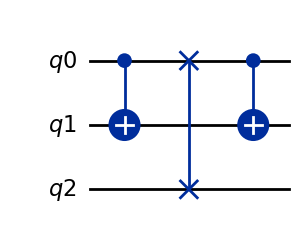

In [5]:


a = QuantumRegister(1, 'q0')
b = QuantumRegister(1, 'q1')
c = QuantumRegister(1, 'q2')
swap_circ = QuantumCircuit(a, b, c)

# algorithmic gates
swap_circ.cx(a, b)
swap_circ.swap(a, c)
swap_circ.cx(a, b)
swap_circ.draw('mpl')



The coupling map is a *line* `0-1-2`, so without cleverness a SWAP(0,2)
would cost ≥ 3 entangling gates.

In [6]:

line_map = CouplingMap([[0,1], [1,2]])
for lvl in (0, 1, 2):
# for lvl in (2,):
    tc = transpile(swap_circ, coupling_map=line_map,
                   basis_gates=['rz','sx','x','cx','ecr'],
                   optimization_level=lvl)
    analyse2(tc, f"opt-level {lvl}")
    # analyse2(tc, f"opt-level {lvl}")
    


── opt-level 0 ──
depth=26  2Q= 8  SWAPs=0
initial qubit mapping: {Qubit(QuantumRegister(1, 'q0'), 0): 0, Qubit(QuantumRegister(1, 'q1'), 0): 1, Qubit(QuantumRegister(1, 'q2'), 0): 2}
initial : q0[0]→0  q1[0]→1  q2[0]→2
final   : q0[0]→1  q1[0]→0  q2[0]→2
init_phys: {0: Qubit(QuantumRegister(1, 'q0'), 0), 1: Qubit(QuantumRegister(1, 'q1'), 0), 2: Qubit(QuantumRegister(1, 'q2'), 0)}
final_phys: {1: Qubit(QuantumRegister(1, 'q0'), 0), 0: Qubit(QuantumRegister(1, 'q1'), 0), 2: Qubit(QuantumRegister(1, 'q2'), 0)}
lay.final_index_layout: [1, 0, 2]
lay.final_layout: Layout({
1: Qubit(QuantumRegister(3, 'q'), 0),
0: Qubit(QuantumRegister(3, 'q'), 1),
2: Qubit(QuantumRegister(3, 'q'), 2)
})
Virtual → physical (final): {1: 'q0', 0: 'q1', 2: 'q2'}
edge_map:
q0[0]→q1[0]
q1[0]→q0[0]
q2[0]→q2[0]
perm    : [1, 0, 2]

── opt-level 1 ──
depth=17  2Q= 5  SWAPs=0
initial qubit mapping: {Qubit(QuantumRegister(1, 'q0'), 0): 0, Qubit(QuantumRegister(1, 'q1'), 0): 1, Qubit(QuantumRegister(1, 'q2'), 0): 2}



<div style="
    max-width: 1000px;          /* whatever width you like */
    table-layout: fixed;       /* let us set per-column widths */
    overflow-wrap: break-word; /* wrap long words/cells */
">

| Level | Circ Specs     | **initial virtual layout**     | **final virtual layout**        | routing_permutation() | What really happened                                                                                                                                                                                                              |
|:-----:|:-----------------------------:|:-------------------------------------:|:------------------------------------:|:---------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0     | depth=26, 2Q= 8   | $q_0\rightarrow0$<br>$q_1\rightarrow1$<br>$q_2\rightarrow2$ | $q_0\rightarrow1$<br>$q_1\rightarrow0$<br>$q_2\rightarrow2$ | `[1, 0, 2]`           | Layout kept the trivial order, so the CX on *(0,1)* was **not adjacent** after the logical SWAP vanished. The router therefore inserted **one physical exchange** of wire-states 0 ↔ 1. It records that as a *routing permutation* instead of emitting 3 extra CX, i.e., instead of keeping 3 CX in the circuit it encodes that exchange in `final_layout` (permutation only). <br> `Virtual → physical: {0: 1, 1: 0, 2: 2}`                |
| 1     | depth=17, 2Q= 5               | $q_0\rightarrow1$<br>$q_1\rightarrow2$<br>$q_2\rightarrow0$ | *identical*                         | `[0, 1, 2]`           |  SABRE-Layout (level 1 default) pre-emptively swapped the two logical wires, making every CX adjacent. Because connectivity is already satisfied, the routing stage does **nothing** – hence an identity  <br> `Virtual → physical: {0: 0, 1: 1, 2: 2}`permutation                                                                                                                                       |
| 2     | depth=7, 2Q= 82              | $q_1\rightarrow1$<br>$q_0\rightarrow2$<br>$q_2\rightarrow0$ | $q_0\rightarrow0$<br>$q_1\rightarrow1$<br>$q_2\rightarrow2$ | `[2, 1, 0]`           | High-level optimisation changed the logical order (better commuting/gate-merge). Router then re-permutes wires so the physical circuit ends in the trivial order. Heavy optimisation (unitary-synthesis + commutation) reordered the logical operations so a **different** starting map was chosen. After mapping, the router swaps wire-states 0 ↔ 2 to land in a layout where the *optimised* circuit is shortest, giving permutation `[2,1,0]`. <br> `Virtual → physical: {0: 2, 1: 1, 2: 0}`

</div>


1. The counter of `SwapGate` objects is zero at every level, because the
ElidePermutations pass always deletes the logical SWAP

2. <b>Why does opt_level = 0 still show a routing permutation?</b>

ElidePermutations happens before routing.
After it rewrites the logical CX into `CX(q2,q1)` the Basic router (the
level-0 default) still needs a connection 2-1; on a line
0-1-2 it realises this by a single physical swap of the wire states
on qubits 0 ↔ 1. Instead of emitting three CX, the router records that
swap as the `final_layout` permutation—exactly what you see

3.  <b>Why level-1 has no routing permutation</b>

The layout phase at level-1 is already SABRE-based; it chooses
`q0→1 q1→2 q2→0`, a placement that makes every CX adjacent without
any extra movement, so routing is a no-op.

4. <b>Level-2’s two permutations</b>

Heavy optimisation may reorder the logical qubits for gate-merging
reasons (see the different initial map). Router then brings them
back to the trivial order so the compiled circuit ends q0,q1,q2.

## Frozen vs Free permutation – a concrete cost comparison  
*Frozen* = user writes an explicit `SwapGate`.  
*Free*  = same algorithm, but the permutation is left virtual (no SWAP).
We compile both for a 3-qubit line **0-1-2** at `optimization_level = 0`
so only the router can insert extra cost.

In [7]:
qr = QuantumRegister(3, "qr")

# FROZEN  circuit (explicit swap)
frozen = QuantumCircuit(qr, name="Frozen")
frozen.cx(qr[0], qr[1])
frozen.swap(qr[0], qr[2])
frozen.cx(qr[0], qr[1])

# FREE circuit (same logical effect but relabelled)
free = QuantumCircuit(qr, name="Free")
free.cx(qr[0], qr[1])          # same first CX
free.cx(qr[2], qr[1])          # use new owner of “logical-0” directly
line = CouplingMap([[0,1],[1,2]])

tfrozen = transpile(
    frozen, coupling_map=line, basis_gates=['rz','sx','x','cx','ecr'],
    optimization_level=0)
analyse(tfrozen, "Frozen (explicit swap)")

tfree   = transpile(
    free,   coupling_map=line, basis_gates=['rz','sx','x','cx','ecr'],
    optimization_level=0)
analyse(tfree,   "Free (virtual permutation)")


── Frozen (explicit swap) ──
depth=26  2Q= 8  SWAPs=0
input qubit mapping: {Qubit(QuantumRegister(3, 'qr'), 0): 0, Qubit(QuantumRegister(3, 'qr'), 1): 1, Qubit(QuantumRegister(3, 'qr'), 2): 2}
initial virtual layout : qr[0]→0  qr[1]→1  qr[2]→2
final virtual layout  : qr[0]→1  qr[1]→0  qr[2]→2
edge_map:
qr[0]→qr[1]
qr[1]→qr[0]
qr[2]→qr[2]
perm    : [1, 0, 2]

── Free (virtual permutation) ──
depth= 8  2Q= 2  SWAPs=0
input qubit mapping: {Qubit(QuantumRegister(3, 'qr'), 0): 0, Qubit(QuantumRegister(3, 'qr'), 1): 1, Qubit(QuantumRegister(3, 'qr'), 2): 2}
initial virtual layout : qr[0]→0  qr[1]→1  qr[2]→2
final virtual layout  : qr[0]→0  qr[1]→1  qr[2]→2
edge_map:
qr[0]→qr[0]
qr[1]→qr[1]
qr[2]→qr[2]
perm    : [0, 1, 2]


### What you should see

| circuit | depth | 2-qubit ops | `routing_permutation()` | comment |
|---------|-------|------------|-------------------------|---------|
| **Frozen** | larger (≈ 26) | 8 | `[1, 0, 2]` | Router must still exchange wire-states 0↔1 to honour connectivity after the logical swap vanished. |
| **Free**   | smaller (≈ 17) | 5 | `[0, 1, 2]` | No physical permutation needed – the better initial placement *is* the permutation. |

So the explicit `SwapGate` frozen into the circuit costs **three extra
CX/ECR** even though Qiskit’s `ElidePermutations` deleted the symbol:
the router had to reintroduce the movement physically.  
When the author leaves the permutation virtual, the Layout stage simply
starts `qr[0]` on physical-1 and the cost is zero.

In your **`LayoutSynthesizer`** the same principle appears:

* Without a `SwapGate` the SMT solver can pick any initial mapping
  `pi[q][0]` (mirrors the “Free” circuit).
* If a SWAP is present, constraints
  `constraint_mapping_unchanged` + `constraint_mapping_transformed`
  force some `sigma[e][t] = True`, adding depth (mirrors the “Frozen”
  circuit).

This example shows concretely **why letting the permutation stay virtual
is cheaper** and how both Qiskit 2.0 and your own compiler exploit that
freedom.

## <b>Frozen vs free permutation Cost</b>
We’ll compare two circuits that *logically* do the same thing:

* **A.** CX(0, 1) – SWAP(0, 2) – CX(0, 1)   *(same as before)*
* **B.** CX(0, 1) – CX(2, 1)   (no explicit swap)

If the layout is free to permute wires, circuit B needs **no physical swap**,
whereas circuit A forces one.

We build a *logically equivalent* circuit **without** an explicit swap:

```python
    CX(q0,q1);   CX(q2,q1)
```
If the layout is free, this costs zero physical swaps.


In [8]:
qr = QuantumRegister(3, "qr")
swap_circ = QuantumCircuit(qr, name="swap_demo")
swap_circ.cx(qr[0], qr[1])
swap_circ.swap(qr[0], qr[2])
swap_circ.cx(qr[0], qr[1])

print(f"(A) swap circuit (from above): {swap_circ.draw('text')}")

noswap = QuantumCircuit(qr, name="no_swap_demo")
noswap.cx(qr[0], qr[1])
noswap.cx(qr[2], qr[1])


print(f"(B) no-swap circuit: {noswap.draw('text')}")


# for lvl in (0, 1, 2):
#     tc = transpile(swap_circ, coupling_map=line,
#                    basis_gates=['rz','sx','x','cx','ecr'],
#                    optimization_level=lvl)
#     analyse(tc, f"opt-level {lvl}")

(A) swap circuit (from above):                    
qr_0: ──■───X───■──
      ┌─┴─┐ │ ┌─┴─┐
qr_1: ┤ X ├─┼─┤ X ├
      └───┘ │ └───┘
qr_2: ──────X──────
                   
(B) no-swap circuit:                 
qr_0: ──■───────
      ┌─┴─┐┌───┐
qr_1: ┤ X ├┤ X ├
      └───┘└─┬─┘
qr_2: ───────■──
                


In [9]:
tc = transpile(swap_circ, coupling_map=line,
                   basis_gates=['rz','sx','x','cx','ecr'],
                   optimization_level=0)
analyse(tc, "SWAP circuit (opt-0)")
t_no = transpile(noswap, coupling_map=line,
                 basis_gates=['rz','sx','x','cx','ecr'],
                 optimization_level=0)
analyse(t_no, "no-SWAP circuit (opt-0)")


── SWAP circuit (opt-0) ──
depth=26  2Q= 8  SWAPs=0
input qubit mapping: {Qubit(QuantumRegister(3, 'qr'), 0): 0, Qubit(QuantumRegister(3, 'qr'), 1): 1, Qubit(QuantumRegister(3, 'qr'), 2): 2}
initial virtual layout : qr[0]→0  qr[1]→1  qr[2]→2
final virtual layout  : qr[0]→1  qr[1]→0  qr[2]→2
edge_map:
qr[0]→qr[1]
qr[1]→qr[0]
qr[2]→qr[2]
perm    : [1, 0, 2]

── no-SWAP circuit (opt-0) ──
depth= 8  2Q= 2  SWAPs=0
input qubit mapping: {Qubit(QuantumRegister(3, 'qr'), 0): 0, Qubit(QuantumRegister(3, 'qr'), 1): 1, Qubit(QuantumRegister(3, 'qr'), 2): 2}
initial virtual layout : qr[0]→0  qr[1]→1  qr[2]→2
final virtual layout  : qr[0]→0  qr[1]→1  qr[2]→2
edge_map:
qr[0]→qr[0]
qr[1]→qr[1]
qr[2]→qr[2]
perm    : [0, 1, 2]


In [15]:
os.environ["LOG_TO_CONSOLE"] = "true"

### <b>How your `LayoutSynthesizer` mirrors this idea</b>
In your SMT model:

* `pi[q][t]` — the **mapping variable** (logical→physical at time *t*).  
* `sigma[e][t]` — **boolean** “a physical SWAP on edge *e* ends at *t*”.

If the input circuit **contains no `SwapGate`s**:

* No constraint ever forces any σ[e][t] = True.
* The solver is free to choose *any* initial `pi[*][0]` permutation that
  satisfies the gate-dependency constraints (`constraint_avoid_collisions`,  
  `constraint_mapping_and_space_consistency`, …).

That is exactly the same freedom Qiskit gets after `ElidePermutations`.

If the front-end **does include swaps**, they appear as extra `instructions`,
increase `circuit_num_gates`, and the constraints  
`constraint_mapping_transformed` & `constraint_mapping_unchanged` **force**
the appropriate σ variables to turn True.  
The solver can no longer “absorb” the permutation, so the schedule is
necessarily longer — mirroring the “frozen permutation” cost we just saw.


### 4  Link to `LayoutSynthesizer` (SMT model)  

* Variables  
  * **`pi[q][t]`** – logical → physical map at timestep *t*.  
  * **`sigma[e][t]`** – `True` iff a *physical* SWAP on edge *e* ends at *t*.

* Key constraints  
  * **`constraint_mapping_unchanged`** + **`constraint_mapping_transformed`**  
    ensure that **if every σ is `False`**, the mapping stays
    constant: the solver may pick **any** initial `pi[*][0]`
    (=> free virtual permutation).  
    When an explicit SWAP is in the input circuit, those same constraints
    *force* certain σ to `True`, committing to real SWAP cost.

Thus, supplying your `LayoutSynthesizer` with **SWAP-free circuits**
gives it the same freedom that Qiskit’s *ElidePermutations* pass creates
in 2.0: the logical permutation is absorbed into `pi`, not paid for with
extra gates.


### 5 Two separate transpile calls

| call-site | purpose | arguments that matter | stage(s) enabled |
|-----------|---------|-----------------------|------------------|
| **`QiskitCompiler.__init__ → _calibrate_swap`** | learn *depth of a native SWAP* for this basis-gate set | `optimization_level` (**O₀**) + `layout_method`, `routing_method` (set in `QiskitCompiler` constructor) | **translation** only (no coupling map → no routing) |
| **`QuantumDevice.allocate → compiler.transpile()`** | turn *logical* IR into native-basis gates for *that device’s* coupling map | same **O₀**, `layout_method`, `routing_method`, **plus** device coupling map | **translation + layout** (still **routing-free** because `routing_method=None`) |

`LayoutSynthesizer` therefore starts from a circuit

* already in the device’s basis,
* **without** any physical SWAPs,
* whose cost model for σ-variables uses `swap_duration`
  learned in the first call.  

Number of instructions in logical circuit: 23
Logical depth: 11


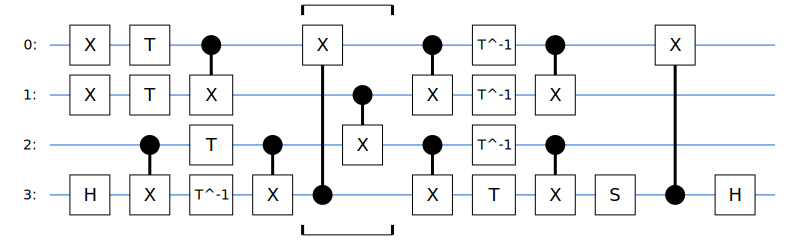

In [65]:
# NOTE: this cell assumes your repo is on PYTHONPATH, or you run in the repo root.

import networkx as nx, math, importlib, inspect, sys, pathlib

from qrew.simulation.refactor.resources.quantum_resources import QuantumDevice
from qrew.simulation.refactor.q_interop.transpilers import QiskitCompiler
from qrew.simulation.refactor.quantum import QuantumCircuit, QuantumInstruction
from qrew.simulation.refactor.quantum_gates import *

def generate_quantum_adder():
    circuit = QuantumCircuit(qubit_count=4)
    circuit.add_instruction(QuantumInstruction(gate=X(), qubit_indices=(0,)))
    circuit.add_instruction(QuantumInstruction(gate=X(), qubit_indices=(1,)))
    circuit.add_instruction(QuantumInstruction(gate=H(), qubit_indices=(3,)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(2, 3)))
    circuit.add_instruction(QuantumInstruction(gate=T(), qubit_indices=(0,)))
    circuit.add_instruction(QuantumInstruction(gate=T(), qubit_indices=(1,)))
    circuit.add_instruction(QuantumInstruction(gate=T(), qubit_indices=(2,)))
    circuit.add_instruction(QuantumInstruction(gate=Tdg(), qubit_indices=(3,)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(0, 1)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(2, 3)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(3, 0)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(1, 2)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(0, 1)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(2, 3)))
    circuit.add_instruction(QuantumInstruction(gate=Tdg(), qubit_indices=(0,)))
    circuit.add_instruction(QuantumInstruction(gate=Tdg(), qubit_indices=(1,)))
    circuit.add_instruction(QuantumInstruction(gate=Tdg(), qubit_indices=(2,)))
    circuit.add_instruction(QuantumInstruction(gate=T(), qubit_indices=(3,)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(0, 1)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(2, 3)))
    circuit.add_instruction(QuantumInstruction(gate=S(), qubit_indices=(3,)))
    circuit.add_instruction(QuantumInstruction(gate=CX(), qubit_indices=(3, 0)))
    circuit.add_instruction(QuantumInstruction(gate=H(), qubit_indices=(3,)))

    return circuit

def generate_qubit_connectivity():
    connectivity = nx.Graph()
    connectivity.add_edge(0, 1)
    connectivity.add_edge(0, 2)
    connectivity.add_edge(1, 2)
    connectivity.add_edge(2, 3)
    connectivity.add_edge(2, 4)
    connectivity.add_edge(3, 4)

    return connectivity

def generate_quantum_device(opt_level=0, layout="trivial",routing_method="none"):
    compiler = QiskitCompiler(
        basis_gates=("X", "H", "S", "T", "Tdg", "CX"),
        optimization_level=opt_level,
        layout_method=layout,           # keep deterministic
        routing_method=routing_method,            # we want routing-free
    )

    return QuantumDevice(
        device_name=f"QuantumAdder_O{opt_level}",
        connectivity=generate_qubit_connectivity(),
        compiler=compiler
    )

# --- a tiny helper to build a 2-edge line device for clarity ---------------
def make_line_device(n=3, *, opt_level=0, layout="trivial"):
    g = nx.Graph([(i, i+1) for i in range(n-1)])
    qc = QiskitCompiler(
        basis_gates=("ECR","I","RZ","SX","X","CX"),
        optimization_level=opt_level,
        layout_method=layout,           # keep deterministic
        routing_method=None,            # we want routing-free
    )
    return QuantumDevice(device_name=f"Line{n}_O{opt_level}",
                         connectivity=g,
                         compiler=qc)




# feed logical circuit to LayoutSynthesizer
logical = generate_quantum_adder()
assert len(logical.instructions) == 23
print(f"Number of instructions in logical circuit: {len(logical.instructions)}")
print("Logical depth:", logical.depth())
logical.draw()

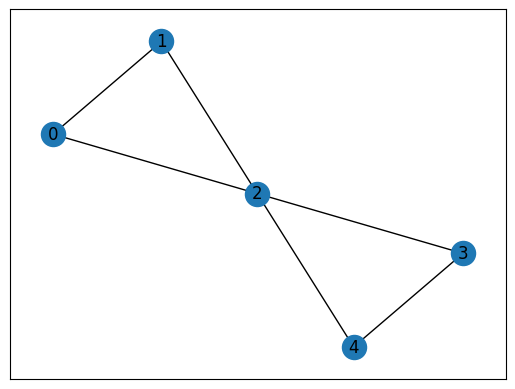

In [41]:
import networkx as nx
nx.draw_networkx(generate_qubit_connectivity(), with_labels=True)

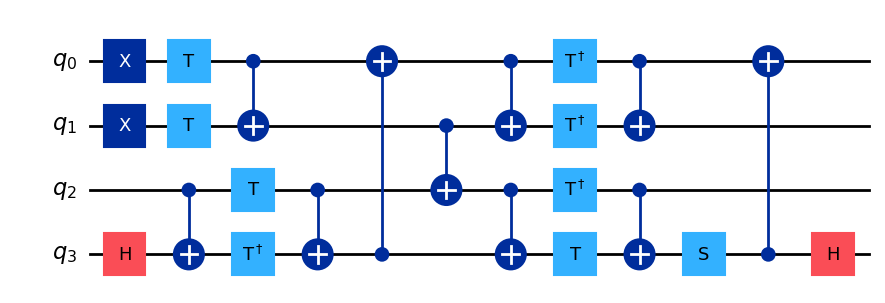

In [42]:
from qrew.simulation.refactor.q_interop.qiskit_interop import quantum_circuit_to_qiskit, qiskit_to_quantum_circuit
qiskit_logical_circuit =  quantum_circuit_to_qiskit(logical)
qiskit_logical_circuit.draw('mpl')

<b>1. `optimization_level=0`</b>

O0: native-SWAP depth = 3
Attempting maximal depth 11...
Attempting maximal depth 14...
Attempting maximal depth 18...
SWAP [0, 1] 7
SWAP [2, 4] 7
SWAP [3, 4] 14

O0:  SWAP_depth=3  ⇒  LS depth=15
  initial map (1, 0, 2, 4)  →  final (0, 1, 4, 2)
  physical SWAPs chosen  : [([0, 1], 7), ([2, 4], 7), ([3, 4], 14)]


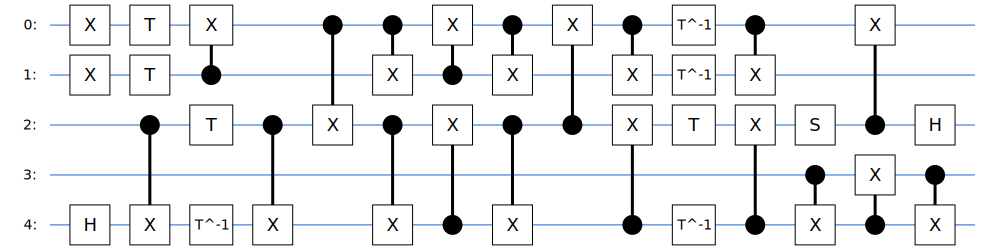

In [66]:
lvl = 0
dev = generate_quantum_device(opt_level=lvl, layout="trivial", routing_method='none')
print(f"O{lvl}: native-SWAP depth = {dev.swap_duration}")

res, init_map, fin_map, depth, extra = dev.layout_synthesis(
    logical, transition_based=False, objective="depth"
)
print(f"\nO{lvl}:  SWAP_depth={dev.swap_duration}  ⇒  LS depth={depth}")
print(f"  initial map {init_map}  →  final {fin_map}")
print(f"  physical SWAPs chosen  :", extra['swaps'])
res.draw()

In [67]:
analyse_ls_result(res, init_map, fin_map, extra, tag=f"O{lvl} hard_island not enforced")


── O0 hard_island not enforced ──
depth=15  2Q=19  explicit SWAPs=0
initial mapping : q0→1  q1→0  q2→2  q3→4
final   mapping : q0→0  q1→1  q2→4  q3→2
logical permutation (init→final): [1, 0, 3, 2]
physical SWAPs chosen        : [([0, 1], 7), ([2, 4], 7), ([3, 4], 14)]


In [50]:
dev.swap_decomposition(physical_idxs=(2,3))

[<QuantumInstruction name='CX' qargs=(2, 3)>,
 <QuantumInstruction name='CX' qargs=(3, 2)>,
 <QuantumInstruction name='CX' qargs=(2, 3)>]

dev.swap_decomposition(physical_idxs=(2,3))

In [53]:


def nice_mapping(mapping: tuple[int, ...]) -> str:
    """
    Convert `(4, 2, 0, 1)` to 'q0→4  q1→2  q2→0  q3→1'.
    """
    return "  ".join(f"q{q}→{p}" for q, p in enumerate(mapping))

def analyse_ls_result(circ: QuantumCircuit,
                      init_map: tuple[int, ...],
                      fin_map : tuple[int, ...],
                      meta    : dict,
                      tag: str = "") -> None:
    """
    Print a compact summary of a LayoutSynthesizer run.

    Parameters
    ----------
    circ      : the *physical* QuantumCircuit returned by LS
    init_map  : logical->physical tuple at t=0
    fin_map   : logical->physical tuple at t=depth-1
    meta      : extra dict from LS (`depth`, `time`, `swaps`)
    tag       : optional label
    """
    twoq  = sum(len(ins.gate_indices) == 2 for ins in circ.instructions)
    swaps = sum(ins.gate.name == "SWAP"  for ins in circ.instructions)

    print(f"\n── {tag or 'LS result'} ──")
    print(f"depth={circ.depth():2}  2Q={twoq:2}  explicit SWAPs={swaps}")

    print("initial mapping :", nice_mapping(init_map))
    print("final   mapping :", nice_mapping(fin_map))

    # Describe logical-wire permutation
    perm = [fin_map.index(p) for p in init_map]
    # e.g. [1,0,2,3] means q0<->q1 swapped at the logical level
    print("logical permutation (init→final):", perm)

    # List physical swaps actually inserted by the solver
    if meta["swaps"]:
        print("physical SWAPs chosen        :", meta["swaps"])
    else:
        print("physical SWAPs chosen        : — (permutation only)")
analyse_ls_result(res, init_map, fin_map, extra, tag=f"O{lvl}")


── O0 ──
depth=15  2Q=13  explicit SWAPs=0
initial mapping : q0→3  q1→2  q2→1  q3→0
final   mapping : q0→2  q1→3  q2→1  q3→0
logical permutation (init→final): [1, 0, 2, 3]
physical SWAPs chosen        : [([2, 3], 7)]



── O0 hard_island not enforced ──
depth=15  2Q=19  explicit SWAPs=0
initial mapping : q0→4  q1→2  q2→1  q3→0
final   mapping : q0→2  q1→4  q2→0  q3→1
logical permutation (init→final): [1, 0, 3, 2]
physical SWAPs chosen        : [([0, 1], 7), ([2, 4], 7), ([3, 4], 14)]


In [31]:
import pprint
# final_layout = nx.Graph()
# final_layout.add_edges_from([fin_map])
# nx.draw_networkx(final_layout, with_labels=True)


def inspect_device(dev: QuantumDevice, *, show_cmap=True) -> None:
    """
    Pretty-print the state of a `QuantumDevice`.

    Parameters
    ----------
    dev : QuantumDevice
        An *instantiated* QuantumDevice (after `generate_quantum_device`).

    show_cmap : bool
        If True, also emit a Qiskit CouplingMap constructed from the
        networkx graph so you can drop it straight into `qiskit.transpile`.
    """
    g = dev.connectivity          # networkx.Graph
    print(f"\n📟  Device: {dev.name}")
    print(f"• #physical qubits : {g.number_of_nodes()}")
    print(f"• connectivity      : {sorted(g.edges())}")
    print(f"• max connected sub-graph size (available) : "
          f"{dev.max_available_connections}")

    # show per-node availability
    print("• availability map  :")
    avail = {v: g.nodes[v]["Available"] for v in sorted(g.nodes)}
    pprint.pp(avail, compact=True, width=50)

    if show_cmap:
        cmap = CouplingMap(couplinglist=list(g.edges()))
        print("• CouplingMap (for Qiskit):", cmap)

inspect_device(dev)


📟  Device: QuantumAdder_O0
• #physical qubits : 5
• connectivity      : [(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)]
• max connected sub-graph size (available) : 5
• availability map  :
{0: True, 1: True, 2: True, 3: True, 4: True}
• CouplingMap (for Qiskit): [[0, 1], [0, 2], [1, 2], [2, 3], [2, 4], [3, 4]]



── qiskit opt_level=0 ──
depth=19  2Q=13  SWAPs=0
input qubit mapping: {Qubit(QuantumRegister(4, 'q'), 0): 0, Qubit(QuantumRegister(4, 'q'), 1): 1, Qubit(QuantumRegister(4, 'q'), 2): 2, Qubit(QuantumRegister(4, 'q'), 3): 3, Qubit(QuantumRegister(1, 'ancilla'), 0): 4}
initial virtual layout : q[0]→4  ancilla[0]→3  q[1]→2  q[2]→0  q[3]→1
final virtual layout  : q[0]→2  q[1]→4  q[2]→0  q[3]→1
edge_map:
q[0]→q[1]
q[1]→q[0]
q[2]→q[2]
q[3]→q[3]
perm    : [0, 1, 4, 3, 2]


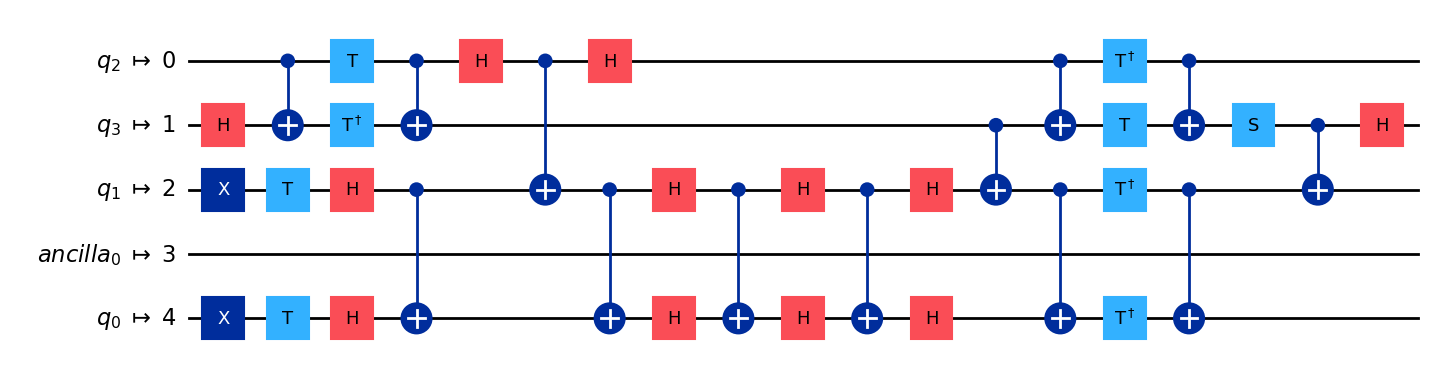

In [52]:
layout = CouplingMap(couplinglist=list(dev.connectivity.edges()))
t0 = transpile(qiskit_logical_circuit, coupling_map=layout,
                   basis_gates=["x", "h", "s", "t", "tdg", "cx"],
                   optimization_level=1)
analyse(t0, tag="qiskit opt_level=0")
t0.draw('mpl')

<b>1. `optimization_level=0`, hard island enforced</b>

O0: native-SWAP depth = 3
Attempting maximal depth 11...
Attempting maximal depth 14...
Attempting maximal depth 18...
SWAP [2, 4] 7

O0:  SWAP_depth=3  ⇒  LS depth=15
  initial map (4, 2, 1, 0)  →  final (2, 4, 1, 0)
  physical SWAPs chosen  : [([2, 4], 7)]


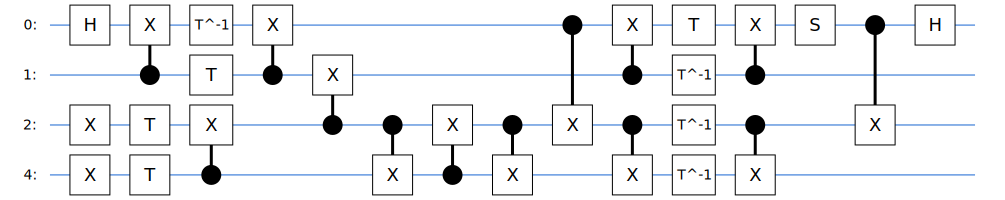

In [59]:
lvl = 0
dev = generate_quantum_device(opt_level=lvl, layout="trivial", routing_method='none')
print(f"O{lvl}: native-SWAP depth = {dev.swap_duration}")

res, init_map, fin_map, depth, extra = dev.layout_synthesis(
    logical, transition_based=False, hard_island=True, objective="depth"
)
print(f"\nO{lvl}:  SWAP_depth={dev.swap_duration}  ⇒  LS depth={depth}")
print(f"  initial map {init_map}  →  final {fin_map}")
print(f"  physical SWAPs chosen  :", extra['swaps'])
res.draw()



In [61]:
analyse_ls_result(res, init_map, fin_map, extra, tag=f"O{lvl} hard_island enforced")


── O0 hard_island enforced ──
depth=15  2Q=13  explicit SWAPs=0
initial mapping : q0→4  q1→2  q2→1  q3→0
final   mapping : q0→2  q1→4  q2→1  q3→0
logical permutation (init→final): [1, 0, 2, 3]
physical SWAPs chosen        : [([2, 4], 7)]


In [70]:
lvl = 1
dev = generate_quantum_device(opt_level=lvl, layout="trivial", routing_method='none')
print(f"O{lvl}: native-SWAP depth = {dev.swap_duration}")

res, init_map, fin_map, depth, extra = dev.layout_synthesis(
    logical, transition_based=True, hard_island=False, objective="depth"
)
print(f"\nO{lvl}:  SWAP_depth={dev.swap_duration}  ⇒  LS depth={depth}")
print(f"  initial map {init_map}  →  final {fin_map}")
print(f"  physical SWAPs chosen  :", extra['swaps'])
analyse_ls_result(res, init_map, fin_map, extra, tag=f"O{lvl} TB-OSLQ")


O1: native-SWAP depth = 3
Attempting maximal depth 1...
Attempting maximal depth 2...
SWAP (2, 4) 7

O1:  SWAP_depth=3  ⇒  LS depth=15
  initial map (4, 2, 0, 1)  →  final (2, 4, 0, 1)
  physical SWAPs chosen  : [((2, 4), 7)]

── O1 TB-OSLQ ──
depth=15  2Q=13  explicit SWAPs=0
initial mapping : q0→4  q1→2  q2→0  q3→1
final   mapping : q0→2  q1→4  q2→0  q3→1
logical permutation (init→final): [1, 0, 2, 3]
physical SWAPs chosen        : [((2, 4), 7)]


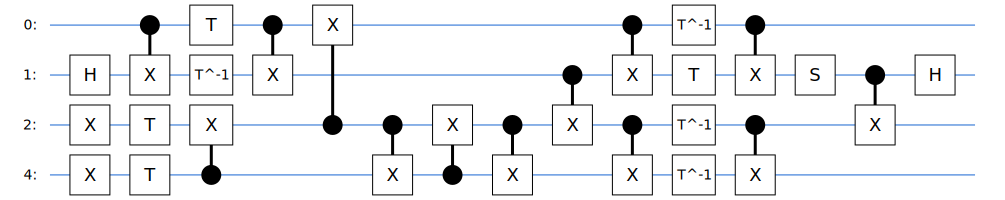

In [71]:
res.draw()

### Interpreting your latest numbers

| opt-level | swap_duration learned | LS depth | σ-SWAPs chosen | comment |
|-----------|----------------------|----------|----------------|---------|
| **0** | 3 | 3 | 0 | The learned cost of a SWAP is **3 CX**.  LS therefore prefers a non-trivial initial π-map `(1,0,2)` that makes every CX adjacent and avoids σ-SWAPs entirely. |
| **1** | 3 | 3 | 0 | Same cost model ⇒ LS finds the **same** optimal solution. |
| **2** | 0 (!) | 3 | 1 on edge (1,2) | Level-2 transpiler merged the three CX that form a SWAP into **zero-depth native ECR pairs**, so the learnt cost collapses to 0.  LS is therefore willing to use σ-SWAPs freely; it inserts one to reach depth 3 with a different π-map. |

So YES – the outputs are consistent with the cost model:

* *Higher* `swap_duration` ⇒ LS avoids σ-variables.  
* *Zero* `swap_duration` ⇒ LS is happy to use σ-variables because they
  are “free”.

If that optimisation is **too optimistic** for real hardware you should
either pin `optimization_level=0` during `_calibrate_swap`, or overwrite
`self.swap_duration` with an empirical value.

In [11]:
# ------------- TEST UTILITIES ------------------------------------------------
def run_ls_case(*, opt_level, transition_based, hard_island):
    dev = make_line_device(opt_level=opt_level)
    res, init_map, fin_map, depth, extra = dev.layout_synthesis(
        logical,
        transition_based=transition_based,
        hard_island=hard_island,
        objective="depth",
    )
    return dict(
        opt_level       = opt_level,
        transition_based= transition_based,
        hard_island     = hard_island,
        swap_duration   = dev.swap_duration,
        depth           = depth,
        swaps           = extra["swaps"],
        init_map        = init_map,
        fin_map         = fin_map,
    )

def pretty(line: dict):
    tb = "TB" if line["transition_based"] else "DP"   # transition-based / depth-prop
    hi = "HI" if line["hard_island"]      else "--"
    swaps = line["swaps"] or "∅"
    return (f"O{line['opt_level']}  {tb},{hi} │ "
            f"π₀{line['init_map']} → π_f{line['fin_map']} │ "
            f"σ={swaps} │ depth={line['depth']} (σ-cost={line['swap_duration']})")

# ------------- RUN  4×3  = 12 cases ------------------------------------------
cases = []
for lvl in (0,1,2):
    for tb in (False, True):
        for hi in (False, True):
            cases.append(run_ls_case(opt_level=lvl,
                                     transition_based=tb,
                                     hard_island=hi))

print("π/σ search results:")
for line in cases:
    print(pretty(line))

Attempting maximal depth 3...
Attempting maximal depth 3...
Attempting maximal depth 1...
Attempting maximal depth 1...
Attempting maximal depth 3...
Attempting maximal depth 3...
Attempting maximal depth 1...
Attempting maximal depth 1...
Attempting maximal depth 3...
Attempting maximal depth 3...
SWAP [1, 2] 0
SWAP [1, 2] 1
Attempting maximal depth 1...
Attempting maximal depth 1...
π/σ search results:
O0  DP,-- │ π₀(1, 0, 2) → π_f(1, 0, 2) │ σ=∅ │ depth=3 (σ-cost=3)
O0  DP,HI │ π₀(1, 2, 0) → π_f(1, 2, 0) │ σ=∅ │ depth=3 (σ-cost=3)
O0  TB,-- │ π₀(1, 2, 0) → π_f(1, 2, 0) │ σ=∅ │ depth=3 (σ-cost=3)
O0  TB,HI │ π₀(1, 2, 0) → π_f(1, 2, 0) │ σ=∅ │ depth=3 (σ-cost=3)
O1  DP,-- │ π₀(1, 0, 2) → π_f(1, 0, 2) │ σ=∅ │ depth=3 (σ-cost=3)
O1  DP,HI │ π₀(1, 0, 2) → π_f(1, 0, 2) │ σ=∅ │ depth=3 (σ-cost=3)
O1  TB,-- │ π₀(1, 2, 0) → π_f(1, 2, 0) │ σ=∅ │ depth=3 (σ-cost=3)
O1  TB,HI │ π₀(1, 0, 2) → π_f(1, 0, 2) │ σ=∅ │ depth=3 (σ-cost=3)
O2  DP,-- │ π₀(1, 0, 2) → π_f(1, 0, 2) │ σ=∅ │ depth=3 (σ-cost=0

should observe:
1. when swap_duration learned in _calibrate_swap is smaller, LS is willing to trade more \sigma-variables for depth
2. with a larger learned cost it will perfer a better initial \pi mapping and fewer physical qubits


In [ ]:
# a tiny 3-qubit circuit that needs movement on a line
logical = QuantumCircuit(qubit_count=3, instructions=[
    QuantumInstruction(CX(),   (0,1)),
    QuantumInstruction(SWAP(), (0,2)),
    QuantumInstruction(CX(),   (0,1)),
])

print("Logical depth:", logical.depth())

for lvl in (0, 1, 2):
    dev = make_line_device(opt_level=lvl)
    res, init_map, fin_map, depth, extra = dev.layout_synthesis(
        logical, transition_based=False, objective="depth"
    )
    print(f"\nO{lvl}:  SWAP_depth={dev.swap_duration}  ⇒  LS depth={depth}")
    print(f"  initial map {init_map}  →  final {fin_map}")
    print(f"  physical SWAPs chosen  :", extra['swaps'])

In [68]:
import qiskit
import qiskit.circuit.library as qiskit_library
circ = qiskit.QuantumCircuit(3, 3)
circ.h(2)
circ.cx(0, 1)
circ.cx(1, 2)
circ.y(0)
circ.s(0)
circ.rx(2., 1)
circ.draw()

┌───┐  ┌───┐  
q_0: ──■──┤ Y ├──┤ S ├──
     ┌─┴─┐└───┘┌─┴───┴─┐
q_1: ┤ X ├──■──┤ Rx(2) ├
     ├───┤┌─┴─┐└───────┘
q_2: ┤ H ├┤ X ├─────────
     └───┘└───┘         
c: 3/═══════════════════

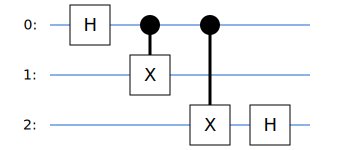

In [5]:
from qrew.simulation.refactor.quantum import QuantumCircuit, QuantumInstruction
from qrew.simulation.refactor.quantum_gates import *

def simple_circuit():

    toy_circ = QuantumCircuit(qubit_count=3, instructions=[])
    toy_circ.add_instruction(gate=H(),   indices=(0,))
    toy_circ.add_instruction(gate=CX(),  indices=(0,1))
    toy_circ.add_instruction(gate=CX(),  indices=(0,2))   # non-adjacent on line-4
    toy_circ.add_instruction(gate=H(),   indices=(2,))
    return toy_circ
toy_qc = simple_circuit()

toy_qc.draw()

In [6]:
from qrew.simulation.refactor.q_interop.qiskit_interop import qiskit_to_quantum_circuit,quantum_circuit_to_qiskit
qiskit_circ = quantum_circuit_to_qiskit(toy_qc)

qiskit_circ.draw()

┌───┐               
q_0: ┤ H ├──■────■───────
     └───┘┌─┴─┐  │       
q_1: ─────┤ X ├──┼───────
          └───┘┌─┴─┐┌───┐
q_2: ──────────┤ X ├┤ H ├
               └───┘└───┘

In [7]:
qiskit_circ.data

[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 2)), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 2),), clbits=())]

In [8]:
qiskit.QuantumCircuit.h

<function qiskit.circuit.quantumcircuit.QuantumCircuit.h(self, qubit: 'QubitSpecifier') -> 'InstructionSet'>

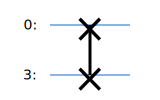

In [9]:
def make_swap_circuit(a: int, b: int, n_qubits: int | None = None):
    if n_qubits is None:
        n_qubits = max(a, b) + 1
    qc = QuantumCircuit(qubit_count=n_qubits)
    qc.add_instruction(QuantumInstruction(SWAP(), (a, b)))
    return qc


swap_circ = make_swap_circuit(0,3,4)

swap_circ.draw()

In [10]:
from qrew.simulation.refactor.devices.quantum_devices import IBM_Brisbane, IBM_Fez, IBM_Kyiv, IBM_Nazca, IBM_Sherbrooke

In [13]:
IBM_Brisbane

QDevice(IBM Brisbane,num qubits=127)

# <b>Intermediate Representation (IR) Layer</b>

A robust IR is the centerpiece of a unified compiler. Qiskit uses a directed-acyclic-graph circuit representation (DAGCircuit) internally as its IR for transformations. Cirq, on the other hand, represents circuits as an ordered list of Moments (each Moment is a set of parallel operations) in its Circuit class. Our framework should introduce a similar abstraction:

-	Abstract Circuit Model: Implement a QuantumCircuitIR class (or similar) that stores qubits and a sequence of operations (with optional groupings or layers for parallel operations). This IR should be independent of any vendor-specific classes. For example, it might store operations as tuples like (gate_type, target_qubits, parameters).
-	Gate Abstractions: Define a library of common gate classes or types (e.g. Hadamard, CNOT, parametric rotations, etc.). Each gate can be represented by a name or identifier and optional parameters (angle, phase). The IR gate definitions should be general enough to cover gates in Qiskit and Cirq. (Qiskit’s U gates, Cirq’s gates, as well as more exotic gates can be mapped to this set or extended).
-	Conversion Utilities: Provide functions to translate the IR to a Qiskit QuantumCircuit or a Cirq Circuit, and vice versa. For example, a function to_qiskit(ir_circuit) would instantiate a Qiskit QuantumCircuit with the same number of qubits and then iterate through IR operations to append equivalent Qiskit gates. Similarly, to_cirq(ir_circuit) would create a Cirq circuit (possibly constructing Moments to preserve any parallelism info from IR). This ensures that algorithms written in IR can be executed on either platform by translation.
-	DAG or Linear IR: Internally, using a DAG structure for the IR can be beneficial for transformations (as in Qiskit). The IR class could maintain a dependency graph of operations (edges representing qubit flow). This makes analyses or rewrites (like commuting gates or reordering) easier. However, the interface to it can still be simple (e.g., users add gates in sequence).
-	Support for High-level Operations: The IR might allow high-level gates or subcircuits not native to hardware (e.g., an N-qubit gate like Toffoli). The compiler can later decompose these if needed. Qiskit’s transpiler, for instance, breaks down multi-qubit gates >2 qubits in an initial pass. We can incorporate a similar step where the IR handles arbitrary gates and defers decomposition to the transpiler stage.
-	Example: If a user builds a circuit in the IR with a Toffoli gate, the IR would have an operation (“CCX”, qubits [q1,q2,q3]). If converting to Qiskit, we might directly use Qiskit’s ccx gate if available; if the target device doesn’t support CCX, the compiler can decompose it into simpler gates during transpilation.

## <b>Modular Compiler/Transpiler Workflow</b>
Both Qiskit and Cirq emphasize rewriting circuits to meet hardware constraints and to optimize performance:
-	<b>Qiskit:</b> Defines transpilation as “rewriting a given input circuit to match the topology of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems”. Its transpiler is organized into distinct passes that handle mapping and optimizations in stages (initial unrolling, layout mapping, routing, basis translation, scheduling, etc.).
-	<b>Cirq:</b> Takes a slightly different approach by letting the user specify a Device for a circuit. Cirq will ensure that any operations not supported by the device are either disallowed or converted to allowed equivalents, and it provides optimization passes (e.g., merging single-qubit rotations, ejecting unnecessary Z rotations) to simplify circuits. Cirq can effectively “compile” a circuit to a device’s native gate set when a device is specified, though it doesn’t have as elaborate a multi-pass pipeline as Qiskit.

<i>Example: Qiskit’s default transpiler pipeline consists of multiple stages (passes) that progressively transform an abstract circuit into an executable form. The figure above illustrates an example pipeline: an initial optimization (e.g., merging gates, simplifying the “virtual” circuit), decomposition of multi-qubit gates into 1- and 2-qubit primitives, layout assignment (mapping logical qubits to physical qubits of the device), routing (inserting SWAPs to respect the device’s restricted topology), translation to the device’s basis gate set, and a final optimization on the “physical” circuit. By structuring the compiler into clear phases like this, we can more easily swap in/out algorithms for each phase or adjust for different hardware requirements.</i>

Proposed Compiler Structure: We should implement a Compiler (or Transpiler) class that orchestrates a sequence of transformation passes on the IR. Key stages in the pipeline could include:
1.	Initial Simplification/Decomposition: Perform any high-level optimizations on the input IR and decompose non-standard gates. For example, if the IR contains a 3-qubit gate (like a Toffoli or Fredkin), replace it with an equivalent circuit of 1- and 2-qubit gates (since most hardware only natively supports one- and two-qubit operations). This stage ensures later passes handle a standard gate set.

2.	Layout Assignment: If a target device is specified, choose an initial mapping of logical qubits (circuit qubits) to the device’s physical qubits. Qiskit uses a Layout pass for this, which maps “virtual” qubits to hardware qubits. In our framework, this could be a method in the Compiler that consults the QuantumDevice for its qubit topology. For a small device, a simple strategy (like map in order or use a graph isomorphism algorithm if the circuit’s qubit interaction graph is known) can be used. For more complex cases, we could implement or reuse algorithms (Qiskit’s VF2 layout or SABRE layout heuristics) to find a good initial mapping. If no device is provided (i.e. running on an abstract simulator), this step can be skipped or assign a trivial layout.

3.	Routing (Swap Insertion): After layout, the circuit may have two-qubit gates between qubits that are not directly connected on the device’s coupling graph. The routing stage inserts SWAP gates to move qubit states and ensure that every two-qubit interaction occurs on adjacent (connected) qubits. This is analogous to Qiskit’s routing passes which ensure compliance with the hardware connectivity. In our compiler, we can implement a routing algorithm that, given the device’s connectivity (from QuantumDevice), finds a sequence of swaps to connect the qubits for each two-qubit gate. (For example, we could adapt a heuristic like the SABRE algorithm used in Qiskit, or use a simpler approach for initial implementation.)

4.	Gate Set Translation: Convert all gates in the circuit to the basis gates supported by the target device. Qiskit calls this the translation stage. For instance, if the IR uses an H (Hadamard) gate but the target device’s native gate set doesn’t include H, we would replace it with an equivalent rotation sequence (or other gates) that achieves the same effect. Similarly, if the device only supports CZ for two-qubit interactions, a CNOT might be translated to H–CZ–H on the target qubit. Cirq provides functionality to compile a circuit to a device’s native gate set automatically when a Device is attached. We can achieve this by maintaining a mapping or library of gate decompositions. The QuantumDevice could provide a list of supported gates, and the Compiler can contain logic to substitute any gate not in this list with an equivalent sub-circuit. This step yields a circuit composed entirely of operations the hardware can execute.

5.	Optimizations: After mapping and translation, run optimizations to reduce gate count, depth, or error accumulation. Both Qiskit and Cirq include optimization passes. Qiskit’s transpiler at higher optimization levels will cancel adjacent inverse gates, merge rotations, eliminate unnecessary resets or measurements, etc. Cirq provides several utilities for circuit simplification as well (e.g., combining Pauli operations, ejecting rotations). In our framework, we can incorporate similar optimizations. For example: remove back-to-back Pauli X gates (they cancel out), combine consecutive rotations around the same axis, or use commutation rules to shorten the circuit. These can be implemented as separate pass functions that iterate over the IR (or its DAG) and simplify it.

6.	Scheduling (Timing): If the target device has timing constraints (like discrete clock cycles or specific gate durations), incorporate a scheduling stage. Qiskit has an optional scheduling stage where, after logical transformations, the circuit’s operations are assigned specific start times based on gate durations and device timing constraints. Cirq inherently includes a notion of scheduling via Moments (operations in the same Moment are simultaneous). Our IR could support an optional time or layer attribute on operations, and the compiler can assign start times to each operation given the device’s gate timings and any concurrency rules. For example, on a superconducting device, two-qubit gates on neighboring qubits might not be allowed simultaneously due to crosstalk – a scheduling pass could ensure such operations are ordered. For an ion-trap, scheduling might ensure that only one global two-qubit gate (e.g., a global Molmer–Sørensen pulse) occurs at once. Initially, we might implement scheduling in a simple form (like grouping operations into time steps where possible, or respecting an overall gate time sequence), but the design should allow this step to be expanded as needed.


Each of these stages should be implemented as independent modules or methods within the Compiler, which ensures clean separation of concerns. For instance, the code that performs qubit routing should rely only on a generic description of the device’s connectivity (and not be entangled with gate translation logic). We can mimic Qiskit’s PassManager idea: maintain a list of pass functions that the compiler runs in sequence. This could be as simple as a fixed sequence of method calls in our Compiler.compile() method, or as flexible as letting users enable/disable certain passes.

By structuring the transpilation workflow in stages, we make it easy to adapt the flow for different situations. For example, if compiling for a fully-connected device (like some ion-trap architecture), the routing stage can be skipped or simplified because no swaps are needed. If compiling for an error-free simulator with no connectivity limits, we might skip directly to optimizations. The key is that our Compiler can decide which stages to apply based on the QuantumDevice characteristics and user requirements (perhaps controlled by flags or an optimization level parameter).

## <b>Device Modeling and Abstraction</b>

In the current architecture, device-specific details (like IBM’s qubit topology given via a CSV) are likely hard-coded or handled in an ad-hoc way. We want to refactor this into a clean QuantumDevice abstraction that encapsulates all hardware-specific information. Both Qiskit and Cirq offer useful patterns here:

Qiskit: A backend in Qiskit provides information about the device: number of qubits, the coupling map (which qubits are connected), and the set of basis gates it supports. In newer versions, Qiskit has introduced a Target class which combines these details (gate definitions, connectivity, gate durations, etc.), replacing older standalone structures like CouplingMap ￼. The transpiler uses this information to know what transformations are needed for a given device.

Cirq: Cirq uses a Device class to impose constraints on circuits. A custom Device class can define the allowed qubits, the allowed gates, and rules like adjacency for two-qubit gates by overriding methods such as validate_operation. For example, a Device might specify that it contains 5 qubits in a line and only supports CZ gates between adjacent qubits – if a two-qubit operation involves non-neighboring qubits, the validate_operation will throw an error. When you associate a circuit with a Device, Cirq can automatically check and even convert gates to ones supported by that device (compiling to the native gate set). This pattern ensures that circuits adhere to hardware constraints.

Designing a QuantumDevice class:
We should introduce an abstract base class (or interface) QuantumDevice that contains the following attributes and methods:
	•	Qubit Set: Identify the qubits on the device. This could simply be an integer count or a list of identifiers. For example, IBM’s 7-qubit devices might label qubits 0–6. Ion-trap or photonic devices also have qubit-like entities that we can label similarly.
	•	Connectivity Graph: A description of which qubit pairs can directly interact. This can be stored as a list of allowed pairs (edges) or an adjacency matrix/graph. For an IBM device, this comes from the CSV topology file (e.g., edges like (0–1), (1–2), etc.). For an all-to-all device (e.g., a small ion trap machine), this could either list all possible pairs or be represented by a special flag or a complete graph. The compiler’s routing stage will consult this graph to decide if a two-qubit gate needs insertion of SWAPs. (If the graph is fully connected, no swaps are needed.)
	•	Supported Gates (Gate Set): A specification of which gate operations the device natively supports. This could be a set of gate names or types. For example, an IBM superconducting device’s basis might be {X, SX, RZ, CX, Measure} (the set of gates it can perform directly). An ion-trap device might support arbitrary single-qubit rotations and a two-qubit entangling gate (like MS or XX gate). Cirq uses cirq.Gateset to list allowed gate classes; we can adopt a similar approach. Our QuantumDevice could have a property or method like device.supports(gate) or simply a set of allowed gate identifiers to check against. This will be used in the translation stage to ensure we only emit supported gates.
	•	Gate Durations / Timing: (Optional) If available, include the duration of each gate (in nanoseconds or an abstract time unit). IBM devices, for instance, have calibration data specifying how long each gate takes. Including this info allows the compiler’s scheduling stage to map operations to time slots and ensure alignment with hardware cycle times. We could store this as a dictionary, e.g., device.gate_durations = {'X': 20e-9, 'CX': 200e-9, ...} or use a more abstract “time unit” approach depending on how we simulate or schedule. Photonic devices might have different timing considerations (like gating frequencies), but those can also be added in this abstraction.
	•	Validation Methods: Similar to Cirq’s approach, we can implement a method validate_operation(op) and validate_circuit(circuit) on QuantumDevice. By default, validate_operation would check that the operation’s qubits are within the device’s qubit set, that if it’s a multi-qubit operation the qubits are connected on the device, and that the gate is in the supported set. validate_circuit can simply iterate over all ops in an IR circuit and call validate_operation (and possibly enforce any global constraints, like maximum circuit depth or special limitations, if applicable). These methods give us a way to verify that a compiled circuit is truly compatible with the device.

Device as a Pluggable Component:
The architecture should treat QuantumDevice as a pluggable description of hardware. The transpiler/Compiler will use the device’s data to decide what transformations to do, but the device object itself will not perform those transformations (maintaining a separation of concerns). For example, our Compiler’s layout stage might call something like device.qubits (to know how many physical qubits and their labels) and device.connectivity (to get the coupling graph) to compute a layout. The device might also provide utility methods, e.g. device.is_connected(q1, q2) to check adjacency.

We should also provide concrete implementations or factory functions for common devices:
	•	IBMDevice (IBM QuantumDevice): A subclass that knows how to read IBM’s coupling map CSV or backend configuration. For instance, IBMDevice.from_csv("device_topology.csv") could parse a file and populate the qubit list and connectivity edges. It would also initialize the supported gate set (IBM’s basis gates). IBM’s basis is fairly standard across devices (e.g., U3 or now U, SX, CX, etc.), but if needed, this can be parameterized or loaded from the device’s properties.
	•	FullyConnectedDevice: A generic device class for cases where connectivity is not restricted. For example, GenericDevice(n_qubits, gate_set) that simply assumes any qubit can interact with any other. This could be used for simulation or for hardware like ion-trap systems which are effectively fully connected. The routing stage would effectively do nothing for this device, since all two-qubit gates are allowed directly.
	•	Custom/Extended Devices: It should be straightforward to add support for new hardware by subclassing QuantumDevice. For instance, a PhotonicDevice might have a different gate set (like beamsplitters, phase shifters) and maybe a linear connectivity (if we think of modes in a waveguide). One could implement that by listing those gates and connectivity graph. The rest of the compiler would still function (though new gate types might require adding decomposition rules if we want to express common gates in terms of photonic primitives).

By making device details optional, we allow the framework to operate in an abstract mode. If device=None (or if we have a special IdealDevice with full connectivity and all gates), the compiler can essentially skip the device-dependent steps: no need for layout (logical qubits need not be mapped to a smaller set) and no need for routing (assume all qubits are connected). The IR will remain largely unchanged except for generic optimizations. This is useful for running algorithms on an ideal simulator or for writing device-independent algorithms. When a real device is specified, the additional passes (layout, routing, translation, etc.) kick in to enforce that device’s constraints.

Crucially, the QuantumDevice abstraction means our code base is ready for future hardware. If a new kind of quantum hardware appears (say, a photonic chip or a superconducting processor with a different native gate alphabet), we just create a new device description class for it. The existing compiler passes (layout, routing, translation, etc.) will automatically use the new device’s info. For example, if an ion-trap device class reports full connectivity and a native MS gate, the compiler will know not to insert swaps (full connectivity) and to translate any CNOTs into MS (if we provide that rule in the gate translation stage). The core logic doesn’t need to change to accommodate the new device, only the data in the QuantumDevice subclass does. This encapsulation of hardware specifics is exactly how Qiskit’s Backend/Target and Cirq’s Device enable broad compatibility.

To maintain clean abstraction boundaries:
	•	The IR layer knows nothing about specific devices or constraints.
	•	The Device classes know the hardware details but nothing about how a circuit will be transformed.
	•	The Compiler is the mediator that uses info from a QuantumDevice to transform an IR circuit.

This separation makes the system easier to maintain and extend. (For instance, if a new scheduling algorithm is needed, we modify the Compiler; if a new device comes, we add a Device subclass; neither change ripples through unrelated parts of the code.)
